In [1]:
import os 
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
##Load variables 
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv('fire_var.env'))

True

In [3]:
# connect to postgres

try:
    conn = psycopg2.connect(database=os.environ.get("erdatabase"), user=os.environ.get("eruser"), 
                            password = os.environ.get("erpassword"), 
                            host=os.environ.get("erhost"), 
                            port=os.environ.get('port'))
    
except psycopg2.Error as e:
    print("I am unable to connect to the database")
    print(e)
    print(e.pgcode)
    print(e.pgerror)
    print(traceback.format_exc())

In [4]:
def pgquery(QUERY): 
    '''
    takes SQL query string, opens a cursor, and executes query in psql
    '''
    
    cur = conn.cursor()
    
    try:
        print("SQL QUERY = "+QUERY)
        cur.execute("SET statement_timeout = 0")
        cur.execute(QUERY)
        # Extract the column names and insert them in header
        col_names = []
        for elt in cur.description:
            col_names.append(elt[0])    
    
        D = cur.fetchall() #convert query result to list
        #pprint(D)
        #conn.close()
        # Create the dataframe, passing in the list of col_names extracted from the description
        return pd.DataFrame(D, columns=col_names)

    except Exception as e:
        print(e.pgerror)



In [5]:
##Pull data from the EC2 instance, display different timepoints in columns
def getTimeDataset(timedesc_dict):
    RESPONSE_TIME_QUERY='''
                        SELECT  I.incident_id, R.responderunit_id, T.responder_id,
                                T.timedesc_id, I.typenaturecode_id, I.fireblock, I.fmarespcomp,
                                T.realtime
                        FROM incident as I
                        INNER JOIN inctimes as T
                                ON I.incident_id = T.incident_id
                        INNER JOIN responder as R
                                ON ( I.incident_id = R.incident_id AND T.responder_id = R.responder_id)
                        WHERE T.timedesc_id IN ??TIMEDESC_IDS??
                                AND T.responder_id IS NOT NULL;
                        '''
    
    # add the timedesc_ids that we want to the query
    timedesc_ids = str(tuple(timedesc_dict.keys())).replace("'", "")
    RESPONSE_TIME_QUERY = RESPONSE_TIME_QUERY.replace("??TIMEDESC_IDS??", str(timedesc_ids))
    
    # execute the query: **this takes a pretty long time**
    df = pgquery(RESPONSE_TIME_QUERY)
    
    # now reshape the data so that we can do analysis more easily. 
    table = df.pivot_table(index=['incident_id', 'responderunit_id', 'typenaturecode_id',
                                  'fireblock', 'fmarespcomp'],
                      columns='timedesc_id', values='realtime', aggfunc='first')
    table.rename(columns=timedesc_dict, inplace=True)
    
    return table

In [6]:
d = {3: 'Dispatched', 5 : 'On Scene', 9: 'Depart Scene', 12: 'Clear'}
table = getTimeDataset(d)

SQL QUERY = 
                        SELECT  I.incident_id, R.responderunit_id, T.responder_id,
                                T.timedesc_id, I.typenaturecode_id, I.fireblock, I.fmarespcomp,
                                T.realtime
                        FROM incident as I
                        INNER JOIN inctimes as T
                                ON I.incident_id = T.incident_id
                        INNER JOIN responder as R
                                ON ( I.incident_id = R.incident_id AND T.responder_id = R.responder_id)
                        WHERE T.timedesc_id IN (9, 3, 12, 5)
                                AND T.responder_id IS NOT NULL;
                        


In [19]:
table.head(10)

timedesc_id                                                                   Dispatched  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03          2010-01-01 00:07:32   
            221.0            147.0             0375      03          2010-01-01 00:07:32   
754222      58.0             134.0             0727      07          2010-01-01 00:04:24   
            218.0            134.0             0727      07          2010-01-01 00:04:24   
754224      232.0            21.0              1109      11          2010-01-01 00:14:15   
            415.0            21.0              1109      11          2010-01-01 00:14:15   
754225      120.0            125.0             2530      25          2010-01-01 00:16:21   
            229.0            125.0             2530      25          2010-01-01 00:16:21   
754226      56.0             141.0             0133      01          2010-01-01 00:21:17   
            123.0            141.0             0133      01          2010-01-01 00:22:11   

timedesc_id                                                                     On Scene  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03                          NaT   
            221.0            147.0             0375      03          2010-01-01 00:09:53   
754222      58.0             134.0             0727      07          2010-01-01 00:08:57   
            218.0            134.0             0727      07          2010-01-01 00:07:14   
754224      232.0            21.0              1109      11          2010-01-01 00:17:01   
            415.0            21.0              1109      11          2010-01-01 00:17:36   
754225      120.0            125.0             2530      25                          NaT   
            229.0            125.0             2530      25          2010-01-01 00:26:53   
754226      56.0             141.0             0133      01          2010-01-01 00:27:50   
            123.0            141.0             0133      01          2010-01-01 00:22:56   

timedesc_id                                                                 Depart Scene  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03                          NaT   
            221.0            147.0             0375      03          2010-01-01 00:22:43   
754222      58.0             134.0             0727      07                          NaT   
            218.0            134.0             0727      07                          NaT   
754224      232.0            21.0              1109      11                          NaT   
            415.0            21.0              1109      11                          NaT   
754225      120.0            125.0             2530      25                          NaT   
            229.0            125.0             2530      25          2010-01-01 00:37:50   
754226      56.0             141.0             0133      01                          NaT   
            123.0            141.0             0133      01                          NaT   

timedesc_id                                                                        Clear  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03          2010-01-01 00:10:59   
            221.0            147.0             0375      03          2010-01-01 00:45:13   
754222      58.0             134.0             0727      07          2010-01-01 00:12:50   
            218.0            134.0             0727      07          2010-01-01 00:11:22   
754224      232.0            21.0              1109      11          2010-01-01 00:52:06   
            415.0            21.0        

In [20]:
##Calculate "Response_Time" and "OnScene_Time"
table["Response_Time"] = table['On Scene'].sub(table['Dispatched'], axis = 0)
table["OnScene_Time"] = table['Clear'].sub(table['On Scene'], axis = 0)

table["Response_Time"].astype('timedelta64[m]')
table["OnScene_Time"].astype('timedelta64[m]')
table.head(20)


timedesc_id                                                                   Dispatched  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03          2010-01-01 00:07:32   
            221.0            147.0             0375      03          2010-01-01 00:07:32   
754222      58.0             134.0             0727      07          2010-01-01 00:04:24   
            218.0            134.0             0727      07          2010-01-01 00:04:24   
754224      232.0            21.0              1109      11          2010-01-01 00:14:15   
            415.0            21.0              1109      11          2010-01-01 00:14:15   
754225      120.0            125.0             2530      25          2010-01-01 00:16:21   
            229.0            125.0             2530      25          2010-01-01 00:16:21   
754226      56.0             141.0             0133      01          2010-01-01 00:21:17   
            123.0            141.0             0133      01          2010-01-01 00:22:11   
            218.0            141.0             0133      01          2010-01-01 00:21:17   
            230.0            141.0             0133      01          2010-01-01 00:23:33   
754227      30.0             141.0             0109      01          2010-01-01 00:09:02   
            215.0            141.0             0109      01          2010-01-01 00:09:02   
754228      33.0             12.0              0127      01          2010-01-01 00:17:31   
            116.0            12.0              0127      01          2010-01-01 00:17:31   
754229      46.0             147.0             2530      25          2010-01-01 00:19:21   
            218.0            147.0             2530      25          2010-01-01 00:21:26   
            230.0            147.0             2530      25          2010-01-01 00:19:21   
754230      116.0            155.0             0127      01          2010-01-01 00:25:34   

timedesc_id                                                                     On Scene  \
incident_id responderunit_id typenaturecode_id fireblock fmarespcomp                       
754221      52.0             147.0             0375      03                          NaT   
            221.0            147.0             0375      03          2010-01-01 00:09:53   
754222      58.0             134.0             0727      07          2010-01-01 00:08:57   
            218.0            134.0             0727      07          2010-01-01 00:07:14   
754224      232.0            21.0              1109      11          2010-01-01 00:17:01   
            415.0            21.0              1109      11          2010-01-01 00:17:36   
754225      120.0            125.0             2530      25                          NaT   
            229.0            125.0             2530      25          2010-01-01 00:26:53   
754226      56.0             141.0             0133      01          2010-01-01 00:27:50   
            123.0            141.0             0133      01          2010-01-01 00:22:56   
            218.0            141.0             0133      01                          NaT   
            230.0            141.0             0133      01          2010-01-01 00:30:27   
754227      30.0             141.0             0109      01          2010-01-01 00:17:39   
            215.0            141.0             0109      01          2010-01-01 00:19:38   
754228      33.0             12.0              0127      01                          NaT   
            116.0            12.0              0127      01          2010-01-01 00:23:24   
754229      46.0             147.0             2530      25          2010-01-01 00:25:06   
            218.0            147.0             2530      25                          NaT   
            230.0            147.0             2530      25                          NaT   
754230      116.0            155.0         

In [21]:
table.describe()
##Looks like there are negative time and very long times  

timedesc_id,year,Response_Time,OnScene_Time
count,1.051459e+06,889921,882483
mean,2.013164e+03,-1 days +23:38:10.949737,0 days 01:26:52.621557
std,2.005796e+00,17 days 01:23:53.266197,38 days 21:26:52.810288
min,2.010000e+03,-16071 days +00:03:54,-366 days +00:08:23
25%,2.011000e+03,0 days 00:03:58,0 days 00:07:15
50%,2.013000e+03,0 days 00:05:10,0 days 00:15:42
75%,2.015000e+03,0 days 00:06:38,0 days 00:49:16
max,2.060000e+03,70 days 06:14:30,36524 days 00:02:02


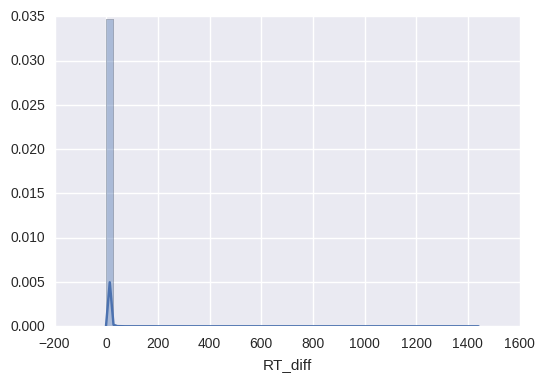

In [42]:
## Plot the distribution of Response_Time
## Ignore negative and time longer than 1 day
table['RT_diff']=table['Response_Time']/pd.Timedelta(minutes=1,seconds=0)
table1 = table.loc[table['RT_diff']>0.0].loc[table['RT_diff']<=1440]
sns.distplot(table1['RT_diff'])

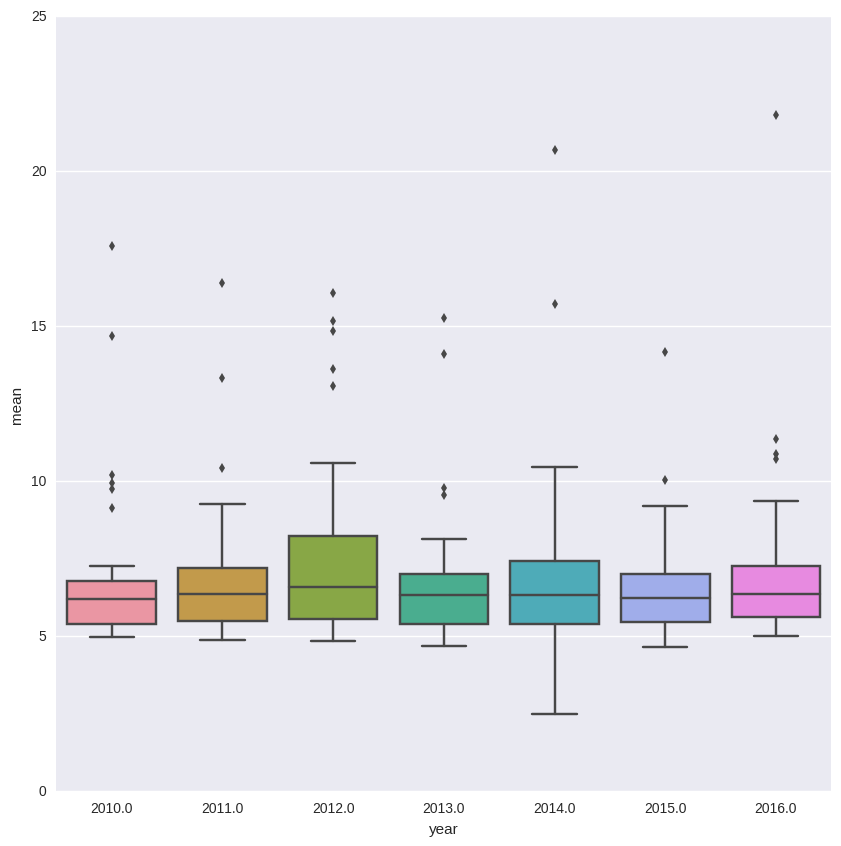

In [67]:
## Most of Response_time is shorter than 30 mins
## Calculate mean of Response_time groupby "year" and "fma"(fire management area)
## Boxplot the means of "fma" cross different "year"
table['year'] =  pd.DatetimeIndex(table['Dispatched']).year
table['fmarespcomp'] = table.index.get_level_values('fmarespcomp')
table1 = table.loc[table['RT_diff']>=1.0].loc[table['RT_diff']<=30.0].copy()
avg_RT = table1.groupby(['year','fmarespcomp'])['RT_diff'].mean().rename('mean').reset_index()
avg_RT = pd.DataFrame(avg_RT)
plt.rcParams['figure.figsize']=(10,10)
ax1 = sns.boxplot(x="year", y="mean", data=avg_RT)


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]), <a list of 55 Text xticklabel objects>)

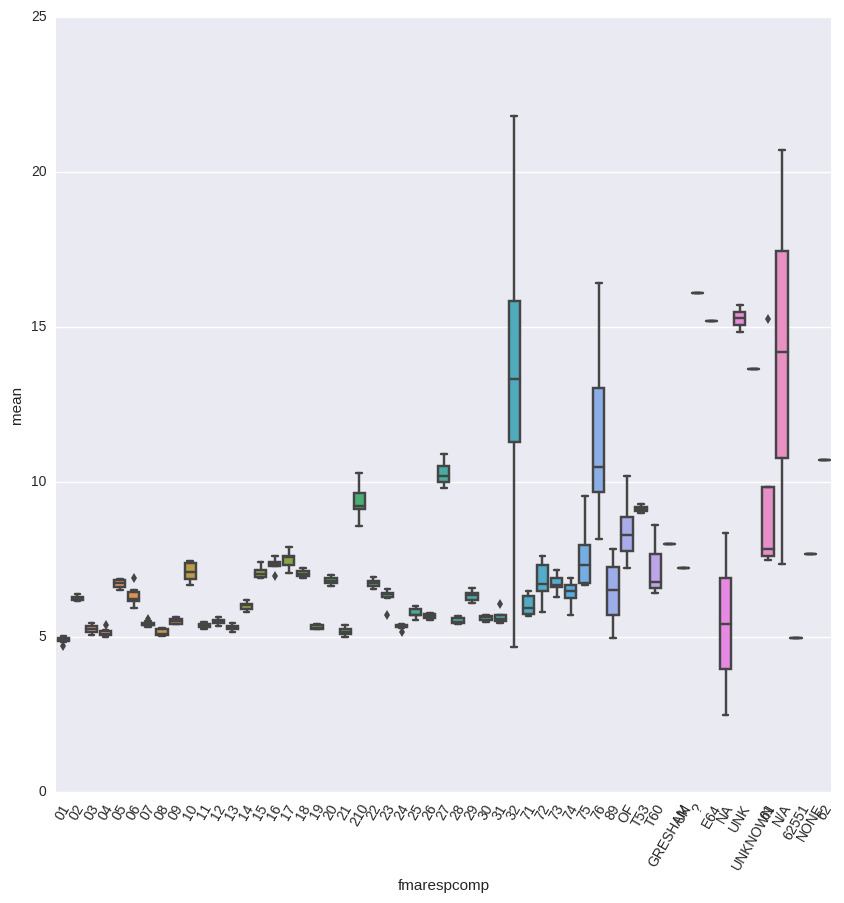

In [68]:
## Boxplot the means of "year" cross different "fma"
ax2 = sns.boxplot(x="fmarespcomp", y="mean", data=avg_RT)
plt.xticks(rotation=60)


In [73]:
avg_RT_overYears = avg_RT['mean'].mean()
avg_RT_overYears

6.92180383387125

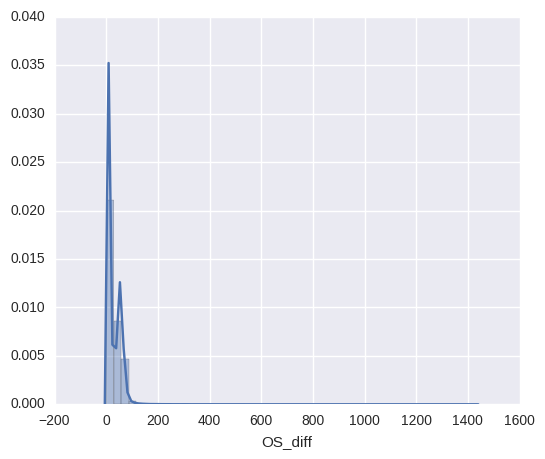

In [72]:
## Plot the distribution of OnScene_Time
## Ignore negative and time longer than 1 day
table['OS_diff']=table['OnScene_Time']/pd.Timedelta(minutes=1,seconds=0)
table1 = table.loc[table['OS_diff']>0.0].loc[table['OS_diff']<=1440]
sns.distplot(table1['OS_diff'])

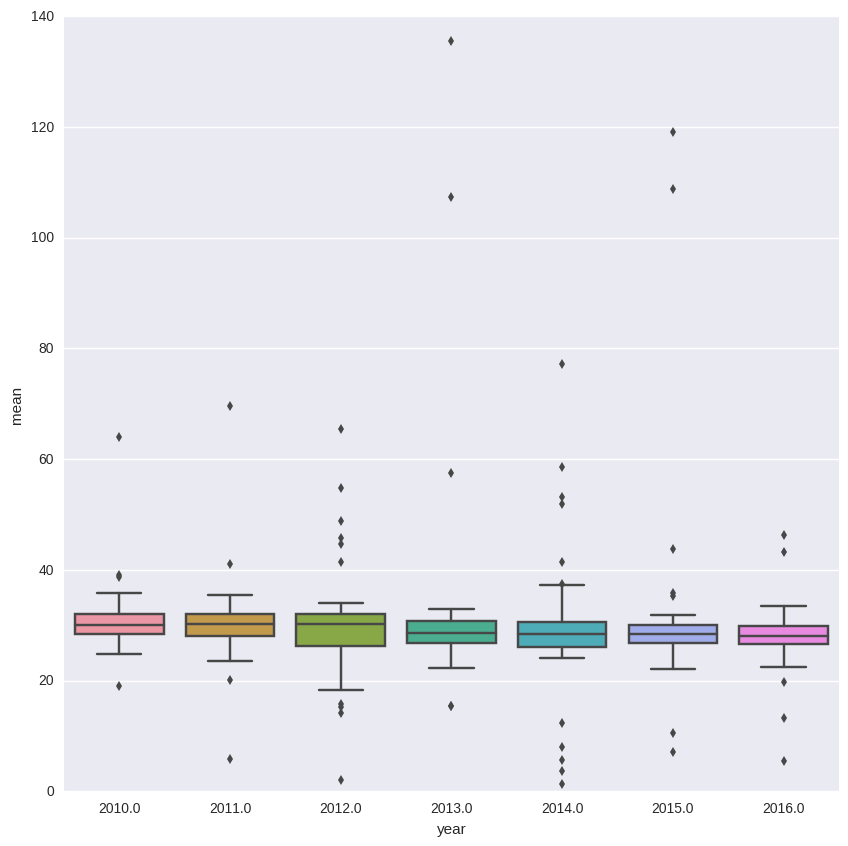

In [61]:
## Most of OnScene_time is shorter than 200 mins
## Calculate mean of OnScene_time groupby "year" and "fma"(fire management area)
## Boxplot the means of "fma" cross different "year"
table2 = table.loc[table['OS_diff']>=1.0].loc[table['OS_diff']<=200.0].loc[table['year']<2017].copy()
avg_OS = table2.groupby(['year','fmarespcomp'])['OS_diff'].mean().rename('mean').reset_index()
avg_OS = pd.DataFrame(avg_OS)
ax3 = sns.boxplot(x="year", y="mean", data=avg_OS)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53]), <a list of 54 Text xticklabel objects>)

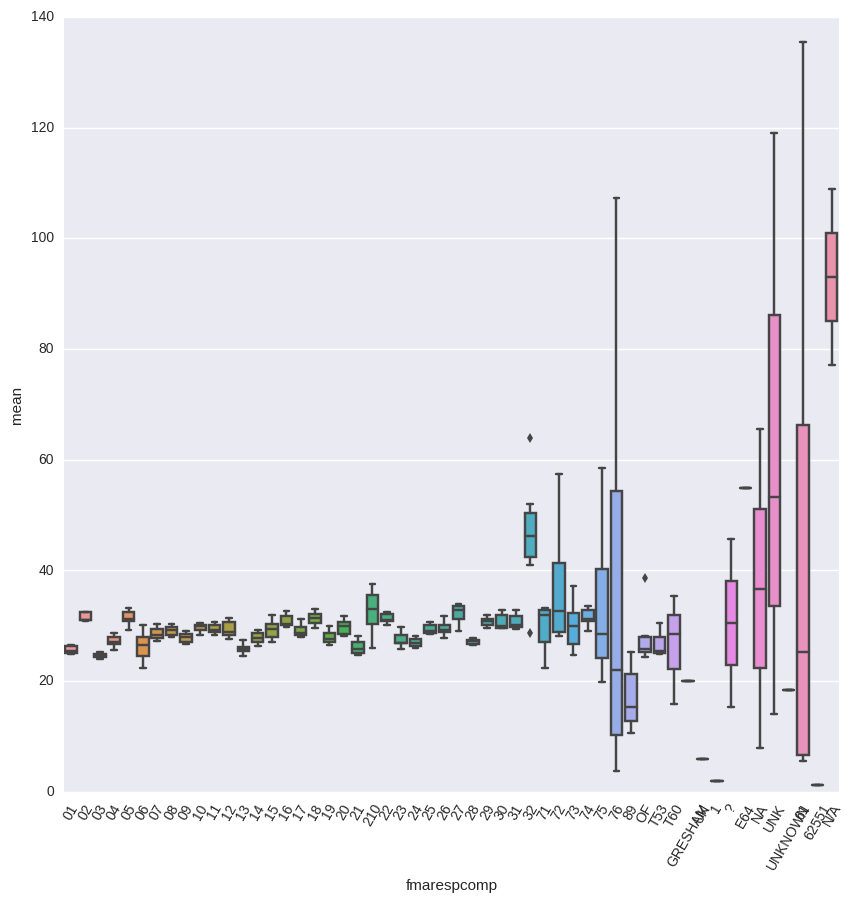

In [70]:
## Boxplot the means of "year" cross different "fma"
ax4 = sns.boxplot(x="fmarespcomp", y="mean", data=avg_OS)
plt.xticks(rotation=60)

In [74]:
avg_OS_overYears = avg_OS['mean'].mean()
avg_OS_overYears

30.437887225886698

In [78]:
avg_OS_2010 = avg_OS.loc[avg_OS['year']== 2010.0].mean()
avg_OS_2010

year    2010.00000
mean      30.86639
dtype: float64

In [79]:
avg_OS_2016 = avg_OS.loc[avg_OS['year']== 2016.0].mean()
avg_OS_2016

year    2016.000000
mean      27.719958
dtype: float64

## Conclusion
__ Average Response_Time is 6.92 min, and average OnScene_Time is 30.44 min. The average OnScene_Time decreased from 30.87 min in 2010 to 27.72 min in 2016. __ 
